In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
## This method is for determening outliers
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper_ouliers = Q3 + 1.5 * IQR
    lower_outliers = Q1 - 1.5 * IQR
    outliers = series[(series < lower_outliers) | (series > upper_ouliers)]
    return len(outliers)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]  

## Content of the tables
### Chemicals table - all of the concentration of the specific chemical, code for the sensor, amount of water(all the data is from 2023)
### Merged_oxygen table - the code of the sensor(it is either 01/07, but it is the same sensor), amount of oxygen, start time, end time(data from 2021)


In [3]:
ammonium = pd.read_parquet('data/Chemical measurements influent 2023_2024/ammonium_2024.parquet')
ammonium['datumBeginMeting'] = pd.to_datetime(ammonium['datumBeginMeting'])
ammonium = ammonium.rename(columns={"hstWaarde": "hstWaarde_ammonium_2023", "historianTagnummer": "historianTagnummer_ammonium", "datumBeginMeting": "datumBeginMeting_ammonium", "datumEindeMeting": "datumEindeMeting_ammonium"}).reset_index(drop=True)
ammonium['hstWaarde_ammonium_2023'] = ammonium['hstWaarde_ammonium_2023'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa6cfd289e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa6cfd28ec0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa6cfd28740>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa6cfd29340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa6cfd295e0>],
 'means': []}

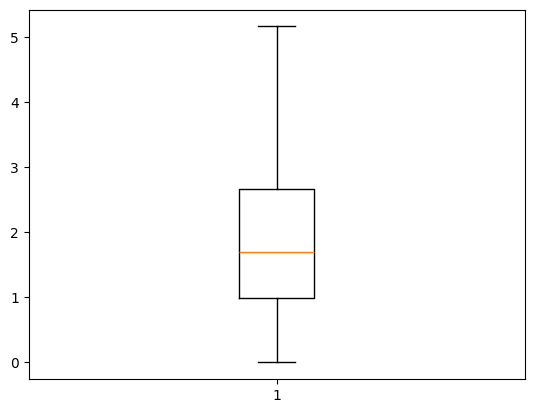

In [12]:
outliers_count = count_outliers_iqr(ammonium['hstWaarde_ammonium_2023'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(ammonium['hstWaarde_ammonium_2023'])

<Axes: >

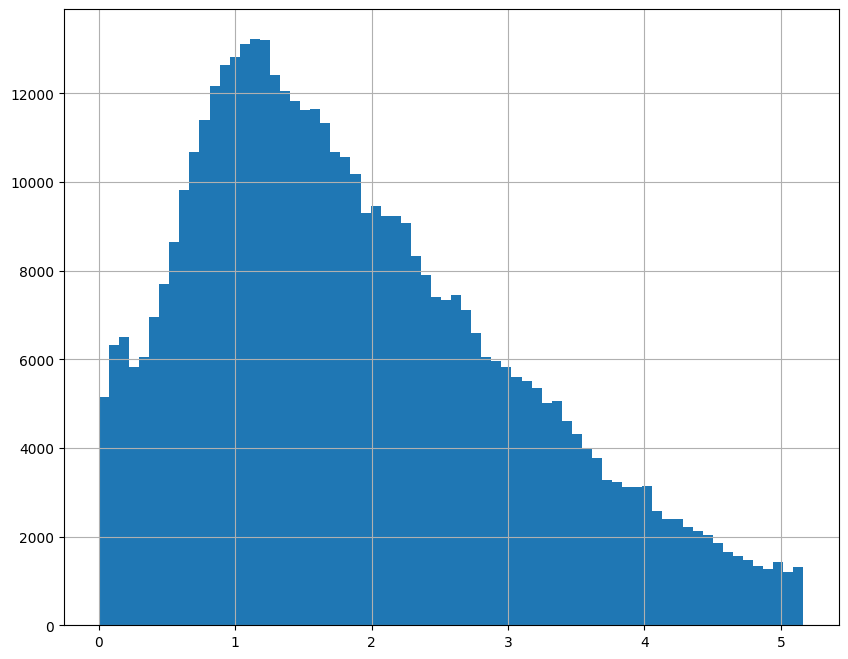

In [11]:
ammonium = remove_outliers_iqr(ammonium, 'hstWaarde_ammonium_2023')
ammonium['hstWaarde_ammonium_2023'].hist(bins=70, figsize=(10, 8))

In [13]:
nitrate = pd.read_parquet('data/Chemical measurements influent 2023_2024/nitrate_2024.parquet')
nitrate['datumBeginMeting'] = pd.to_datetime(nitrate['datumBeginMeting'])
nitrate = nitrate.rename(columns={"hstWaarde": "hstWaarde_nitrate", "historianTagnummer": "historianTagnummer_nitrate", "datumBeginMeting": "datumBeginMeting_nitrate", "datumEndeMeting": "datumEndeMeting_nitrate"}).reset_index(drop=True)
nitrate['hstWaarde_nitrate'] = nitrate['hstWaarde_nitrate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa69dfe0500>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa69dfe0aa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa69dfe0230>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa69dfe1010>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa69dfe1220>],
 'means': []}

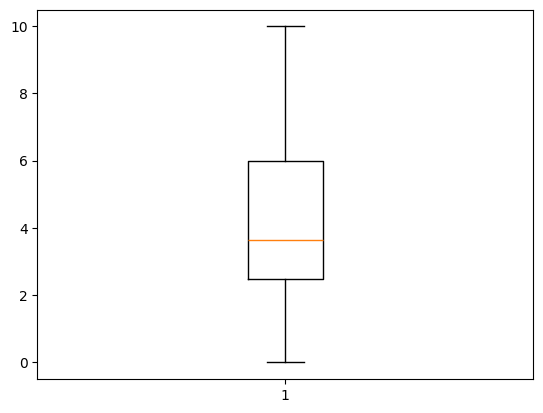

In [14]:
outliers_count = count_outliers_iqr(nitrate['hstWaarde_nitrate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(nitrate['hstWaarde_nitrate'])

<Axes: >

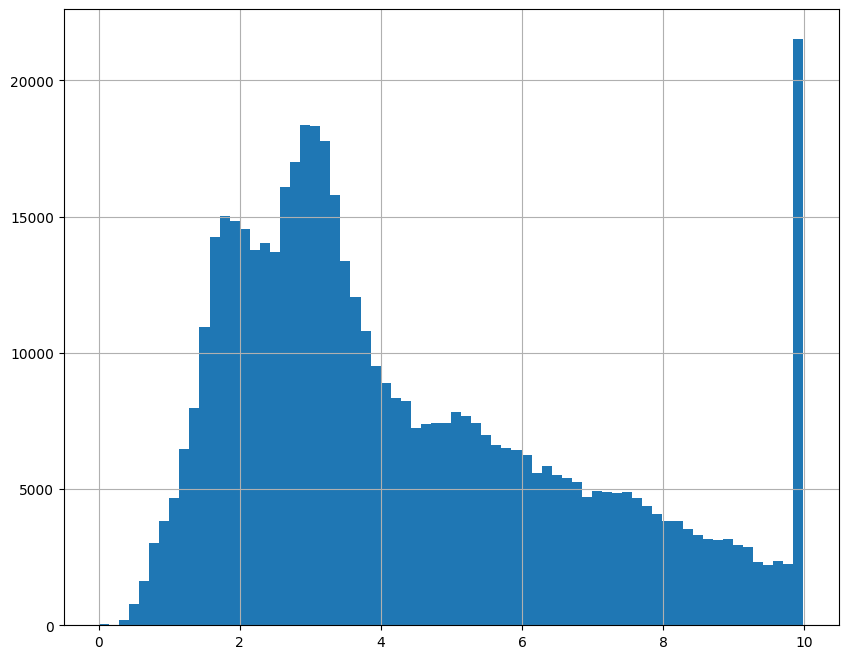

In [15]:
nitrate = remove_outliers_iqr(nitrate, 'hstWaarde_nitrate')
nitrate['hstWaarde_nitrate'].hist(bins=70, figsize=(10, 8))

In [16]:
phosphate = pd.read_parquet('data/Chemical measurements influent 2023_2024/phosphate_2024.parquet')
phosphate['datumBeginMeting'] = pd.to_datetime(phosphate['datumBeginMeting'])
phosphate = phosphate.rename(columns={"hstWaarde": "hstWaarde_phosphate", "historianTagnummer": "historianTagnummer_phosphate"}).reset_index(drop=True)
phosphate['hstWaarde_phosphate'] = phosphate['hstWaarde_phosphate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa6cc04a180>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa6afe56e40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa6afe56750>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa6afe57440>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa6afe576e0>],
 'means': []}

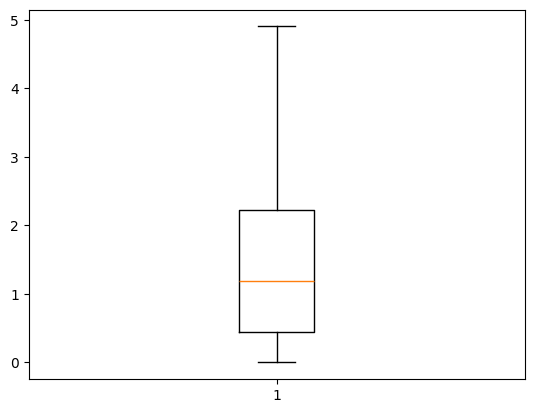

In [25]:
outliers_count = count_outliers_iqr(phosphate['hstWaarde_phosphate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(phosphate['hstWaarde_phosphate'])

<Axes: >

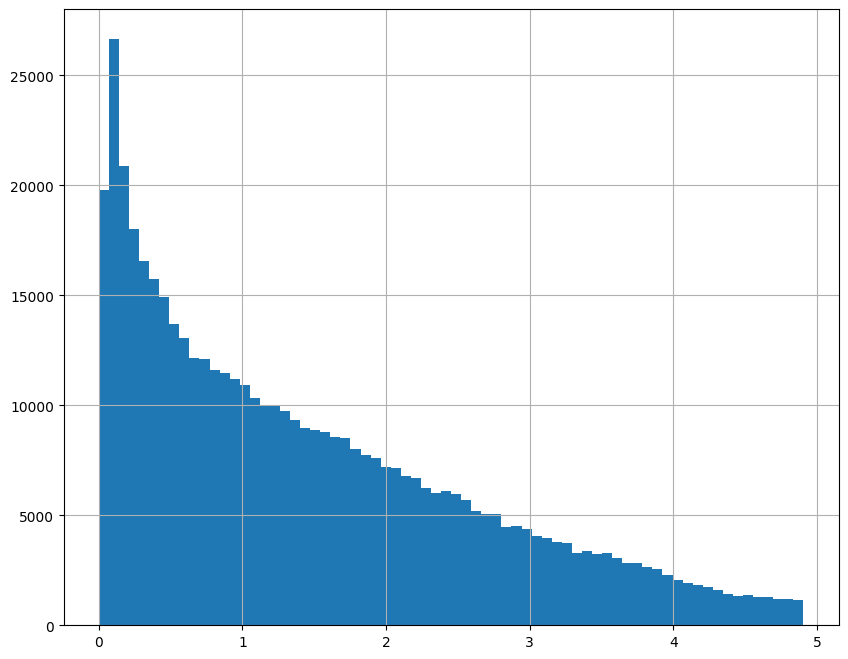

In [26]:
phosphate = remove_outliers_iqr(phosphate, 'hstWaarde_phosphate')
phosphate['hstWaarde_phosphate'].hist(bins=70, figsize=(10, 8))

In [27]:
ammonium_desc = ammonium.describe()
nitrate_desc = nitrate.describe()
phosphate_desc = phosphate.describe()

ammonium_desc.columns = [f'Ammonium_{col}' for col in ammonium_desc.columns]
nitrate_desc.columns = [f'Nitrate_{col}' for col in nitrate_desc.columns]
phosphate_desc.columns = [f'Phosphate_{col}' for col in phosphate_desc.columns]

summary_df = pd.concat([ammonium_desc, nitrate_desc, phosphate_desc], axis=1)
summary_df

,Ammonium_hstWaarde_ammonium_2023,Ammonium_datumBeginMeting_ammonium,Nitrate_hstWaarde_nitrate,Nitrate_datumBeginMeting_nitrate,Phosphate_hstWaarde_phosphate,Phosphate_datumBeginMeting
count,467054.000000,467054,525049.000000,525049,495965.000000,495965
mean,1.905225,2023-06-30 05:12:31.064460032,4.384240,2023-07-02 15:12:05.443720192,1.465640,2023-07-04 18:35:28.532013056
min,0.000000,2023-01-01 00:00:00,0.000000,2023-01-01 00:00:00,0.000000,2023-01-01 00:00:00
25%,0.998000,2023-04-02 09:54:15,2.482000,2023-04-02 10:32:00,0.450000,2023-04-05 12:36:00
50%,1.699000,2023-06-28 03:19:30,3.635000,2023-07-02 16:24:00,1.184000,2023-07-05 12:09:00
75%,2.665000,2023-09-27 12:01:45,6.004000,2023-10-01 21:17:00,2.232000,2023-10-03 16:47:00
max,5.165000,2023-12-31 23:59:00,9.990000,2023-12-31 23:59:00,4.905000,2023-12-31 23:59:00
std,1.168827,NaN,2.461896,NaN,1.192599,NaN


In [28]:
water_flow = pd.read_parquet('data/Influent_Flow_2023.parquet')
water_flow = water_flow.rename(columns={"hstWaarde": "hstWaarde_water"}).reset_index(drop=True)
water_flow['hstWaarde_water'] = water_flow['hstWaarde_water'].apply(pd.to_numeric, errors='coerce')

In [29]:
chemicals = pd.concat([ammonium, nitrate, phosphate], axis=1)
chemicals = chemicals.drop(columns=['waardebewerkingsmethodeCode', 'datumEindeMeting', 'datumBeginMeting_nitrate',
                                    'historianTagnummer_ammonium', 'datumBeginMeting_ammonium', 'datumEindeMeting_ammonium',
                                    'historianTagnummer_nitrate', 'historianTagnummer_phosphate'])
chemicals['hstWaarde_ammonium_2023'] = chemicals['hstWaarde_ammonium_2023'].fillna(chemicals['hstWaarde_ammonium_2023'].median())
chemicals

,hstWaarde_ammonium_2023,hstWaarde_nitrate,hstWaarde_phosphate,datumBeginMeting
0,1.310,4.730,0.001,2023-01-01 00:00:00
1,1.251,4.730,0.001,2023-01-01 00:01:00
2,1.182,4.730,0.000,2023-01-01 00:02:00
3,1.181,4.675,0.000,2023-01-01 00:03:00
4,1.179,4.605,0.000,2023-01-01 00:04:00
...,...,...,...,...
524703,1.699,9.956,1.171,2023-12-31 18:14:00
524704,1.699,9.954,1.160,2023-12-31 18:15:00
524705,1.699,9.953,1.089,2023-12-31 18:16:00
524706,1.699,9.951,0.937,2023-12-31 18:17:00


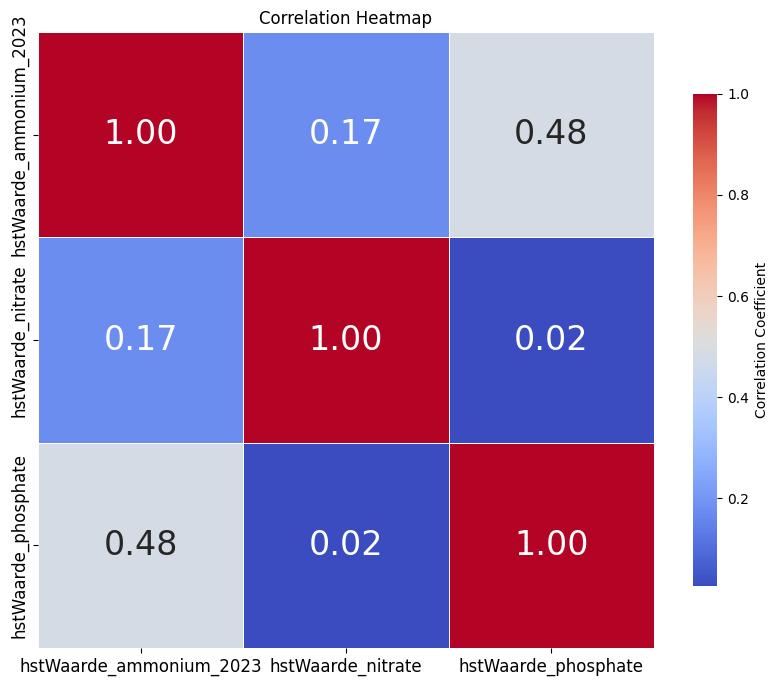

In [30]:
chemicalsForCorr = chemicals[['hstWaarde_ammonium_2023', 'hstWaarde_nitrate', 'hstWaarde_phosphate']]
corr = chemicalsForCorr.corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation Heatmap")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(
    corr,
    annot=True,
    annot_kws={"size": 24},       # Font size for numbers
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}  # Optional
)
plt.show()

Text(0.5, 1.0, 'Distribution of ammonium in 2021')

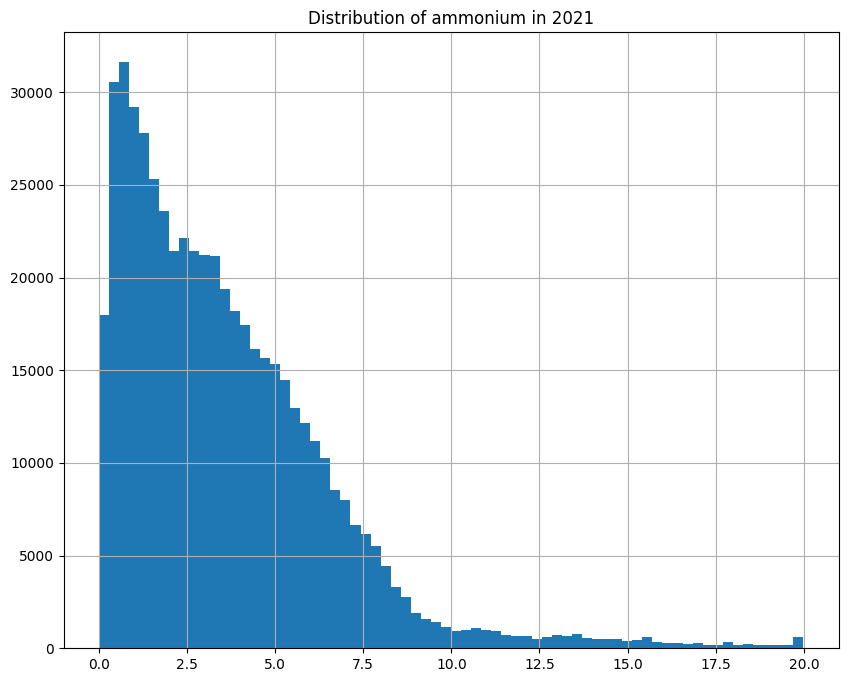

In [31]:
sensor_13 = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Data/EDE_B121069913_K600.MTW.parquet')
sensor_13['hstWaarde'] = sensor_13['hstWaarde'].apply(pd.to_numeric, errors='coerce')
sensor_13 = sensor_13.rename(columns={"hstWaarde": "hstWaarde_ammonium_2021"}).reset_index(drop=True)
sensor_13.hist(bins=70, figsize=(10, 8))
plt.title(f'Distribution of ammonium in 2021')

Text(0.5, 1.0, 'Distribution of ammonium in 2023')

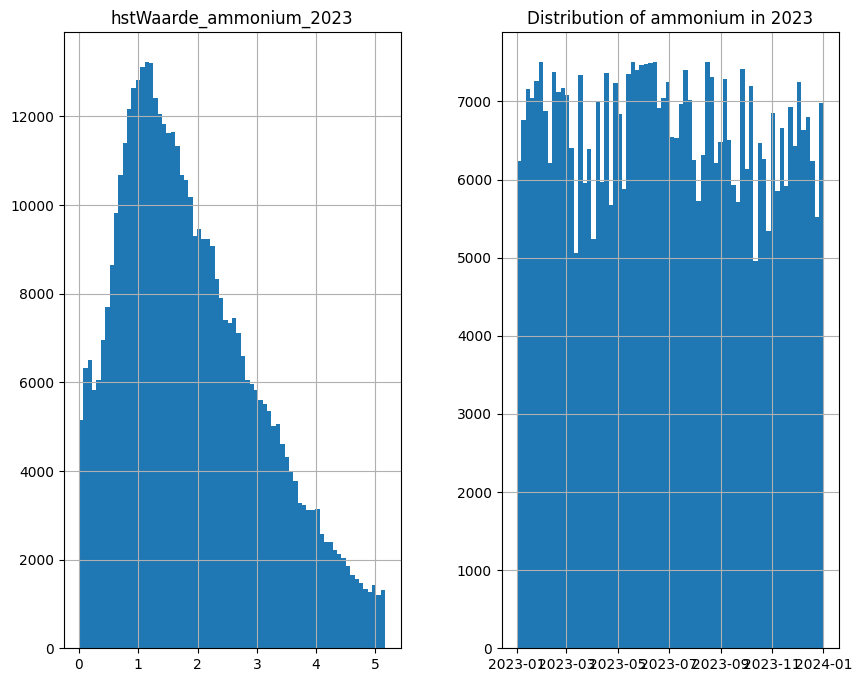

In [32]:
ammonium.hist(bins=70, figsize=(10, 8))
plt.title(f'Distribution of ammonium in 2023')

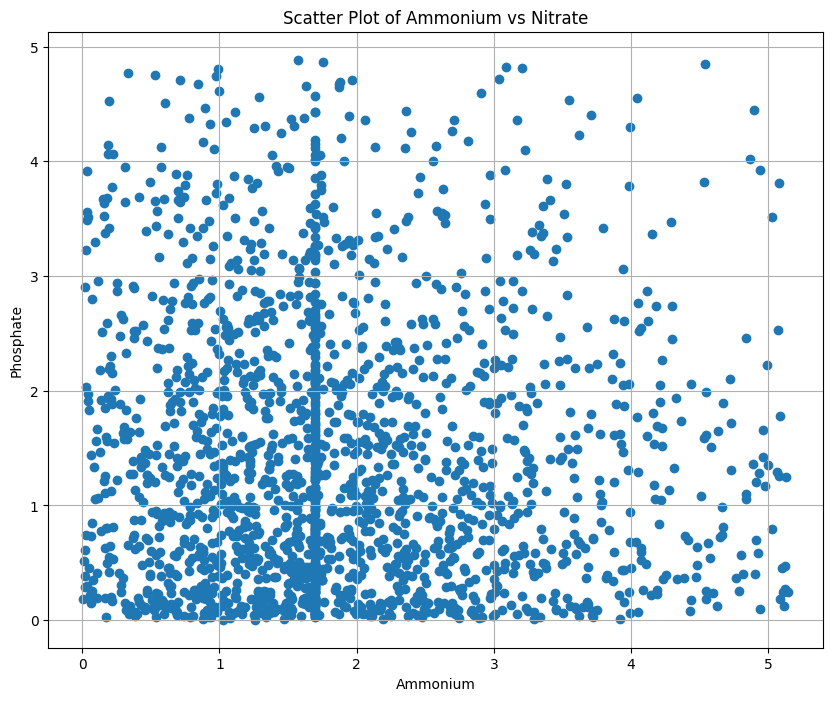

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(chemicals['hstWaarde_ammonium_2023'].sample(2000), chemicals['hstWaarde_phosphate'].sample(2000))
plt.xlabel('Ammonium')
plt.ylabel('Phosphate')
plt.title('Scatter Plot of Ammonium vs Nitrate')
plt.grid(True)

In [34]:
oxygen_a = pd.read_parquet('data/OxygenData2024/oxygen_a_2024.parquet')
oxygen_a = oxygen_a.drop(columns=['waardebewerkingsmethodeCode'])
legacy_oxygen_a = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofA_EDE_B121069901_K600.MTW.parquet')
oxygen_a = oxygen_a.rename(columns={"hstWaarde": "hstWaarde_oxygen_a", "historianTagnummer": "historianTagnummer_oxygen_a"}).reset_index(drop=True)
oxygen_a['hstWaarde_oxygen_a'] = oxygen_a['hstWaarde_oxygen_a'].apply(pd.to_numeric, errors='coerce')

oxygen_b = pd.read_parquet('data/OxygenData2024/oxygen_b_2024.parquet')
oxygen_b = oxygen_b.drop(columns=['waardebewerkingsmethodeCode'])
legacy_oxygen_b = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofB_EDE_B121069907_K600.MTW.parquet')
oxygen_b = oxygen_b.rename(columns={"hstWaarde": "hstWaarde_oxygen_b", "historianTagnummer": "historianTagnummer_oxygen_b"}).reset_index(drop=True)
oxygen_b['hstWaarde_oxygen_b'] = oxygen_b['hstWaarde_oxygen_b'].apply(pd.to_numeric, errors='coerce')

In [35]:
combines_oxygen = pd.concat([oxygen_a, oxygen_b], axis=1)
combines_oxygen['Average_value'] = (combines_oxygen['hstWaarde_oxygen_a'] + combines_oxygen['hstWaarde_oxygen_b']) / 2
combines_oxygen

,historianTagnummer_oxygen_a,hstWaarde_oxygen_a,datumBeginMeting,datumEindeMeting,historianTagnummer_oxygen_b,hstWaarde_oxygen_b,datumBeginMeting,datumEindeMeting,Average_value
0,EDE_B121069901_K600.MTW,1.663,2023-01-01 00:00:00,2023-01-01 00:01:00,EDE_B121069907_K600.MTW,0.777,2023-01-01 00:00:00,2023-01-01 00:01:00,1.2200
1,EDE_B121069901_K600.MTW,1.789,2023-01-01 00:01:00,2023-01-01 00:02:00,EDE_B121069907_K600.MTW,0.982,2023-01-01 00:01:00,2023-01-01 00:02:00,1.3855
2,EDE_B121069901_K600.MTW,2.105,2023-01-01 00:02:00,2023-01-01 00:03:00,EDE_B121069907_K600.MTW,1.189,2023-01-01 00:02:00,2023-01-01 00:03:00,1.6470
3,EDE_B121069901_K600.MTW,2.271,2023-01-01 00:03:00,2023-01-01 00:04:00,EDE_B121069907_K600.MTW,1.266,2023-01-01 00:03:00,2023-01-01 00:04:00,1.7685
4,EDE_B121069901_K600.MTW,2.168,2023-01-01 00:04:00,2023-01-01 00:05:00,EDE_B121069907_K600.MTW,1.403,2023-01-01 00:04:00,2023-01-01 00:05:00,1.7855
...,...,...,...,...,...,...,...,...,...
525044,EDE_B121069901_K600.MTW,1.635,2023-12-31 23:55:00,2023-12-31 23:56:00,EDE_B121069907_K600.MTW,0.596,2023-12-31 23:55:00,2023-12-31 23:56:00,1.1155
525045,EDE_B121069901_K600.MTW,1.841,2023-12-31 23:56:00,2023-12-31 23:57:00,EDE_B121069907_K600.MTW,0.726,2023-12-31 23:56:00,2023-12-31 23:57:00,1.2835
525046,EDE_B121069901_K600.MTW,1.816,2023-12-31 23:57:00,2023-12-31 23:58:00,EDE_B121069907_K600.MTW,0.843,2023-12-31 23:57:00,2023-12-31 23:58:00,1.3295
525047,EDE_B121069901_K600.MTW,1.812,2023-12-31 23:58:00,2023-12-31 23:59:00,EDE_B121069907_K600.MTW,0.880,2023-12-31 23:58:00,2023-12-31 23:59:00,1.3460


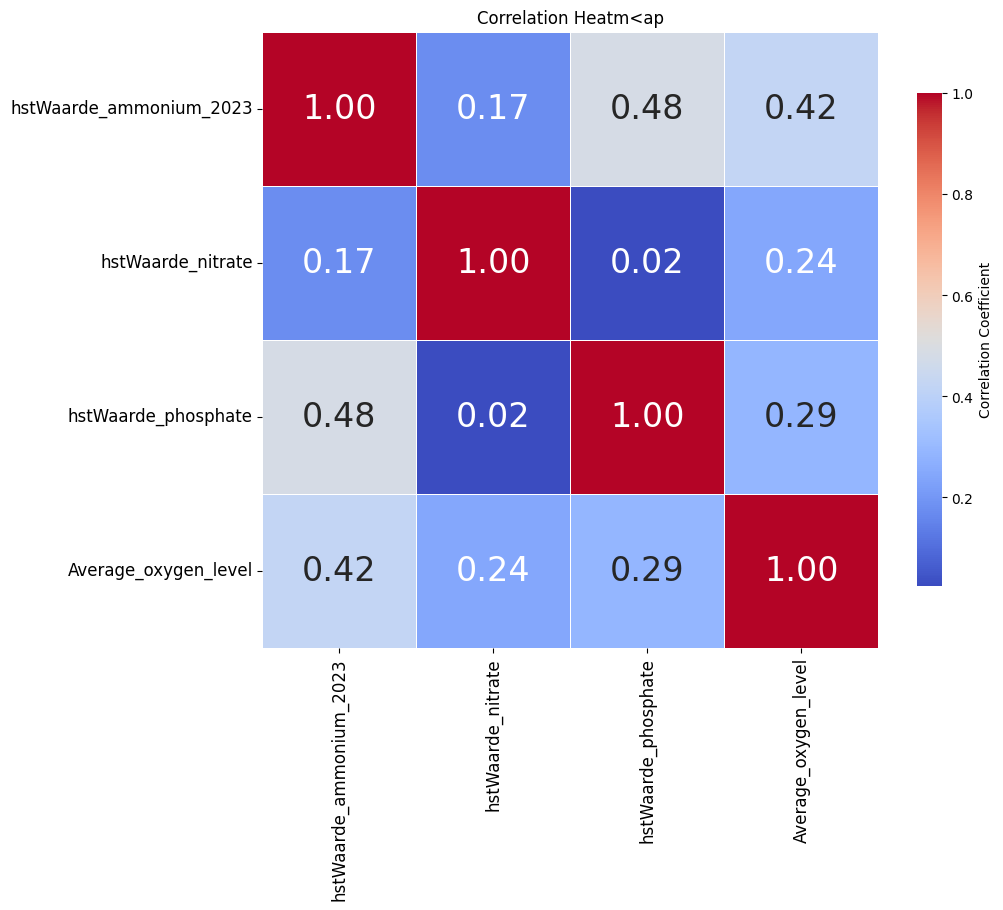

In [36]:
chemicals['Average_oxygen_level'] = combines_oxygen['Average_value']
chemicals.dropna()
ObjectsForCorr = chemicals[['hstWaarde_ammonium_2023', 'hstWaarde_nitrate', 'hstWaarde_phosphate', 'Average_oxygen_level']]
corr = ObjectsForCorr.corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation Heatm<ap")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(
    corr,
    annot=True,
    annot_kws={"size": 24},       # Font size for numbers
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}  # Optional
)
plt.show()

In [37]:
weather = pd.read_csv('weather.csv')
weather

,Timestamp,Station,WindDirection,WindSpeedMean_10min,WindSpeedLast10Min,WindGustMax,Temperature,MinTemp_10cm_6hr,DewPointTemp,SunshineDuration,...,Visibility,CloudCover,RelativeHumidity,WeatherCode,WeatherCodeIndicator,Fog,Rain,Snow,Thunder,IceFormation
0,2023-01-01 00:00:00,275,220,100,90,150,153,,76,0,...,82,8,59,23,7,0,1,0,0,0
1,2023-01-01 01:00:00,275,220,100,90,170,146,,77,0,...,83,8,63,81,7,0,1,0,0,0
2,2023-01-01 02:00:00,275,210,90,90,140,150,,67,0,...,83,8,57,23,7,0,1,0,0,0
3,2023-01-01 03:00:00,275,220,90,90,150,147,,64,0,...,83,8,57,,5,0,0,0,0,0
4,2023-01-01 04:00:00,275,240,80,70,180,141,,72,0,...,83,8,63,23,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,275,200,60,70,110,81,,46,0,...,62,8,78,51,7,0,1,0,0,0
8756,2023-12-31 20:00:00,275,200,80,70,130,82,,47,0,...,72,8,78,81,7,0,1,0,0,0
8757,2023-12-31 21:00:00,275,200,80,90,140,85,,43,0,...,75,8,74,81,7,0,1,0,0,0
8758,2023-12-31 22:00:00,275,200,80,80,130,83,,42,0,...,75,7,75,23,7,0,1,0,0,0


In [38]:
chemicals['datumBeginMeting'] = pd.to_datetime(chemicals['datumBeginMeting'])
chemicals['Hour'] = chemicals['datumBeginMeting'].dt.floor('h')
hourly_chemicals = chemicals.groupby('Hour')[[
    'hstWaarde_ammonium_2023',
    'hstWaarde_nitrate',
    'hstWaarde_phosphate'
]].mean().reset_index()

hourly_chemicals

,Hour,hstWaarde_ammonium_2023,hstWaarde_nitrate,hstWaarde_phosphate
0,2023-01-01 00:00:00,1.037983,4.424633,0.003450
1,2023-01-01 01:00:00,1.938650,3.062367,0.380733
2,2023-01-01 02:00:00,1.885600,3.344783,0.169217
3,2023-01-01 03:00:00,0.933100,2.867483,0.161217
4,2023-01-01 04:00:00,0.772933,2.491967,0.112783
...,...,...,...,...
8511,2023-12-31 19:00:00,2.728717,9.777850,0.503533
8512,2023-12-31 20:00:00,3.159783,9.974633,0.351133
8513,2023-12-31 21:00:00,1.736383,9.390367,0.135667
8514,2023-12-31 22:00:00,1.838267,9.643633,0.152550


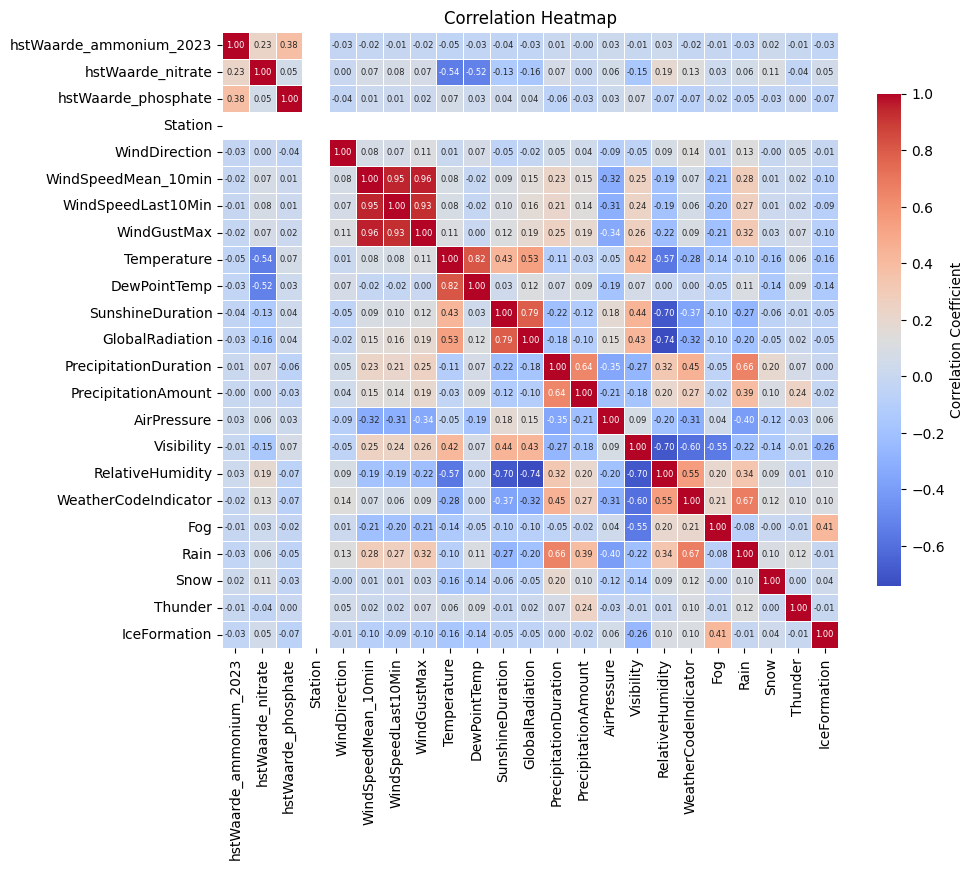

In [39]:
chemicals['Average_oxygen_level'] = combines_oxygen['Average_value']
chemicals.dropna()
combined = pd.concat([hourly_chemicals[['hstWaarde_ammonium_2023', 'hstWaarde_nitrate', 
                                 'hstWaarde_phosphate']], weather], axis=1)
combined.dropna()
numeric_cols = combined.select_dtypes(include='number')
corr = numeric_cols.corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation Heatmap")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(
    corr,
    annot=True,
    annot_kws={"size": 6},       # Font size for numbers
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}  # Optional
)
plt.show()

# Modelling with one-hot encoding 

In [40]:
combined['hstWaarde_ammonium_2023'] = combined['hstWaarde_ammonium_2023'].fillna(combined['hstWaarde_ammonium_2023'].median())
combined['hstWaarde_nitrate'] = combined['hstWaarde_nitrate'].fillna(combined['hstWaarde_nitrate'].median())
combined['hstWaarde_phosphate'] = combined['hstWaarde_phosphate'].fillna(combined['hstWaarde_phosphate'].median())
combined

,hstWaarde_ammonium_2023,hstWaarde_nitrate,hstWaarde_phosphate,Timestamp,Station,WindDirection,WindSpeedMean_10min,WindSpeedLast10Min,WindGustMax,Temperature,...,Visibility,CloudCover,RelativeHumidity,WeatherCode,WeatherCodeIndicator,Fog,Rain,Snow,Thunder,IceFormation
0,1.037983,4.424633,0.003450,2023-01-01 00:00:00,275,220,100,90,150,153,...,82,8,59,23,7,0,1,0,0,0
1,1.938650,3.062367,0.380733,2023-01-01 01:00:00,275,220,100,90,170,146,...,83,8,63,81,7,0,1,0,0,0
2,1.885600,3.344783,0.169217,2023-01-01 02:00:00,275,210,90,90,140,150,...,83,8,57,23,7,0,1,0,0,0
3,0.933100,2.867483,0.161217,2023-01-01 03:00:00,275,220,90,90,150,147,...,83,8,57,,5,0,0,0,0,0
4,0.772933,2.491967,0.112783,2023-01-01 04:00:00,275,240,80,70,180,141,...,83,8,63,23,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1.699000,3.541183,1.314208,2023-12-31 19:00:00,275,200,60,70,110,81,...,62,8,78,51,7,0,1,0,0,0
8756,1.699000,3.541183,1.314208,2023-12-31 20:00:00,275,200,80,70,130,82,...,72,8,78,81,7,0,1,0,0,0
8757,1.699000,3.541183,1.314208,2023-12-31 21:00:00,275,200,80,90,140,85,...,75,8,74,81,7,0,1,0,0,0
8758,1.699000,3.541183,1.314208,2023-12-31 22:00:00,275,200,80,80,130,83,...,75,7,75,23,7,0,1,0,0,0


In [41]:
target = 'hstWaarde_nitrate'
X = combined.drop(columns=[target])
y = combined[target]

In [52]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [62]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

In [63]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [64]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [65]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=0.5))
])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [68]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [69]:
print(f"Ridge Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Ridge Regression Results:
Mean Squared Error (MSE): 3.46
R² Score: 0.39
